# Comparing the Estimation Methods

We conducted a simulation study demonstrating the performances of Meir et al. (2022) [1] and comparing it with that of Lee et al. (2018) [2]. The *PyDTS* implementation was used for both methods. 

The data was generated using the `EventTimesSampler` with $M=2$ competing events, $n=20,000$ observations, $Z$ with 10 covariates and right censoring. 

Failure times were generated based on 

$$
\lambda_{j}(t|Z) = \frac{\exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+\exp(\alpha_{jt}+Z^{T}\beta_{j})}
$$

with 

$\alpha_{1t} = -2.5 - 0.3 \log(t)$, 

$\alpha_{2t} = -2.8 - 0.3 \log(t)$, $t=1,\ldots,d$,

$\beta_1 = -0.5*(\log 0.8, \log 3, \log 3, \log 2.5, \log 4, \log 1, \log 3, \log 2, \log 2, \log 3)$, 

$\beta_{2} = -0.5*(\log 1, \log 3, \log 2, \log 1, \log 4, \log 3, \log 4, \log 3, \log 3, \log 4)$. 

Censoring time for each observation was sampled from a discrete distribution with $P(C_i = t) = \frac{0.1}{d}$ for $t=1,\ldots,d$, and $P(C_i = d+1) = 0.9$. As before, $X=\min(C,T)$ and $J$ is the event type with $J_i=0$ (censoring) if and only if $C_i < T_i$.

We repeated this procedure for $d \in \{ 10, 20, 30, 40, 50 \}$. For each value of $d$, the results are based on 10 replications. 

We show that the computational running time of our approach is shorter depending on $d$, where the improvement factor increases as a function of $d$.

In [1]:
import pandas as pd
import numpy as np
import os
from time import time
from pydts.fitters import TwoStagesFitter, DataExpansionFitter
from pydts.data_generation import EventTimesSampler
from matplotlib import pyplot as plt
pd.set_option("display.max_rows", 500)
%matplotlib inline
slicer = pd.IndexSlice

In [2]:
OUTPUT_DIR = ''

In [11]:
real_coef_dict = {
    "alpha": {
        1: lambda t: -2.5 - 0.3 * np.log(t),
        2: lambda t: -2.8 - 0.3 * np.log(t)
    },
    "beta": {
        1: -0.5*np.log([0.8, 3, 3, 2.5, 4, 1, 3, 2, 2, 3]),
        2: -0.5*np.log([1, 3, 2, 1, 4, 3, 4, 3, 3, 2])
    }
}

n_patients = 20000
n_cov = 10
j_events = 2

d_times = 50
ets = EventTimesSampler(d_times=d_times, j_event_types=j_events)

seed = 0

covariates = [f'Z{i}' for i in range(n_cov)]

COEF_COL = '   coef   '
STDERR_COL = ' std err '

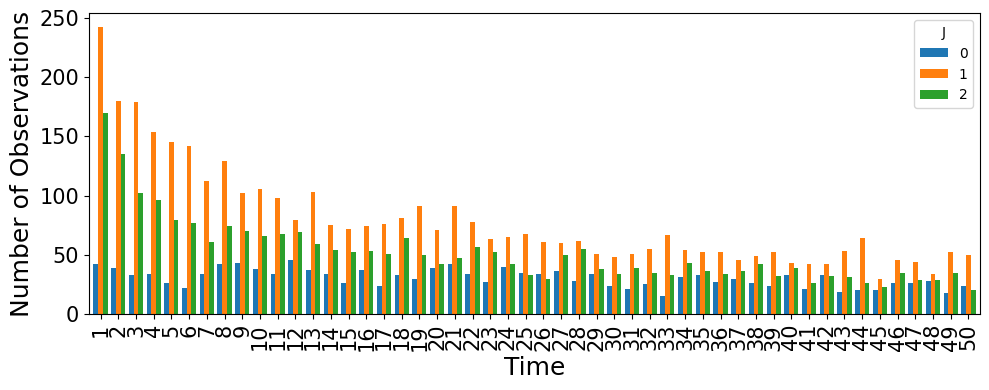

<AxesSubplot:xlabel='Time', ylabel='Number of Observations'>

In [12]:
patients_df = pd.DataFrame(data=pd.DataFrame(data=np.random.uniform(0,1, size=[n_patients, n_cov]),
                           columns=covariates))
                           
patients_df = ets.sample_event_times(patients_df, hazard_coefs=real_coef_dict, seed=seed)
patients_df = ets.sample_independent_lof_censoring(patients_df, prob_lof_at_t=(0.1 / d_times) * np.ones_like(ets.times[:-1]))
patients_df = ets.update_event_or_lof(patients_df)

patients_df.index.name='pid'                 
patients_df = patients_df.reset_index()

from pydts.examples_utils.plots import plot_events_occurrence
plot_events_occurrence(patients_df[patients_df['X'] != (d_times+1)])
#plot_events_occurrence(patients_df)

In [5]:
k_runs = 10
d_times_list = [10, 20, 30, 40, 50]

In [6]:
final_two_step = {}
final_lee = {}

for idp, d_times in enumerate(d_times_list):
    
    case = f'timing_d{d_times}_final_'
    two_step_timing = []
    lee_timing = []
    print(f"Starting d={d_times} times")
    #print('**************************************')
    for k in range(k_runs):
        try:
            # Sampling based on different seed each time
            loop_seed = 1000*idp+k+seed
            print(f'Sampling Patients, loop seed: {loop_seed}')
            np.random.seed(loop_seed)
            ets = EventTimesSampler(d_times=d_times, j_event_types=j_events)
            patients_df = pd.DataFrame(data=pd.DataFrame(data=np.random.uniform(0,1, size=[n_patients, n_cov]),
                                       columns=covariates))
            
            patients_df = ets.sample_event_times(patients_df, hazard_coefs=real_coef_dict, seed=loop_seed)
            patients_df = ets.sample_independent_lof_censoring(patients_df, prob_lof_at_t=(0.1 / d_times) * np.ones_like(ets.times[:-1]))
            patients_df = ets.update_event_or_lof(patients_df)
            patients_df.index.name='pid'
            patients_df = patients_df.reset_index()

            # Two step fitter
            new_fitter = TwoStagesFitter()
            print(f'Starting two-step: {k+1}/{k_runs}')
            two_step_start = time()
            new_fitter.fit(df=patients_df.drop(['C', 'T'], axis=1), nb_workers=1)
            two_step_end = time()
            print(f'Finished two-step: {k+1}/{k_runs}, {two_step_end-two_step_start}sec')

            two_step_timing.append(two_step_end-two_step_start)
            
            # Lee et al fitter
            lee_fitter = DataExpansionFitter()
            print(f'Starting Lee: {k+1}/{k_runs}')
            lee_start = time()
            lee_fitter.fit(df=patients_df.drop(['C', 'T'], axis=1))
            lee_end = time()
            print(f'Finished lee: {k+1}/{k_runs}, {lee_end-lee_start}sec')

            lee_timing.append(lee_end-lee_start) 

            lee_alpha_ser = lee_fitter.get_alpha_df().loc[:, slicer[:, [COEF_COL, STDERR_COL] ]].unstack().sort_index()
            lee_beta_ser = lee_fitter.get_beta_SE().loc[:, slicer[:, [COEF_COL, STDERR_COL] ]].unstack().sort_index()

            if k == 0:
                two_step_alpha_k_results = new_fitter.alpha_df[['J', 'X', 'alpha_jt']]
                two_step_beta_k_results = new_fitter.get_beta_SE().unstack().to_frame()

                lee_alpha_k_results = lee_alpha_ser.to_frame()
                lee_beta_k_results = lee_beta_ser.to_frame()

            else:
                two_step_alpha_k_results = pd.concat([two_step_alpha_k_results, new_fitter.alpha_df['alpha_jt']], axis=1)
                two_step_beta_k_results = pd.concat([two_step_beta_k_results, new_fitter.get_beta_SE().unstack()], axis=1)

                lee_alpha_k_results = pd.concat([lee_alpha_k_results, lee_alpha_ser], axis=1)
                lee_beta_k_results = pd.concat([lee_beta_k_results, lee_beta_ser], axis=1)


        except Exception as e:
            print(f'Failed during trial {k}')
            print(e)
            

    two_step_alpha_k_results = two_step_alpha_k_results.set_index(['J', 'X'])
    two_step_alpha_k_results.columns = list(range(1, 1+k_runs))
    two_step_beta_k_results.columns = list(range(1, 1+k_runs))
    lee_alpha_k_results.columns = list(range(1, 1+k_runs))
    lee_beta_k_results.columns = list(range(1, 1+k_runs))
    
    final_two_step[d_times] = two_step_timing
    final_lee[d_times] = lee_timing

Starting d=10 times
Sampling Patients, loop seed: 0
Starting two-step: 1/10
Finished two-step: 1/10, 8.427181005477905sec
Starting Lee: 1/10
Finished lee: 1/10, 29.56827998161316sec
Sampling Patients, loop seed: 1
Starting two-step: 2/10
Finished two-step: 2/10, 8.293389081954956sec
Starting Lee: 2/10
Finished lee: 2/10, 29.079202890396118sec
Sampling Patients, loop seed: 2
Starting two-step: 3/10
Finished two-step: 3/10, 8.216938018798828sec
Starting Lee: 3/10
Finished lee: 3/10, 29.072221040725708sec
Sampling Patients, loop seed: 3
Starting two-step: 4/10
Finished two-step: 4/10, 8.227971076965332sec
Starting Lee: 4/10
Finished lee: 4/10, 29.057978868484497sec
Sampling Patients, loop seed: 4
Starting two-step: 5/10
Finished two-step: 5/10, 8.172473907470703sec
Starting Lee: 5/10
Finished lee: 5/10, 29.534367084503174sec
Sampling Patients, loop seed: 5
Starting two-step: 6/10
Finished two-step: 6/10, 8.265614986419678sec
Starting Lee: 6/10
Finished lee: 6/10, 29.13016986846924sec
Samp

Sampling Patients, loop seed: 4009
Starting two-step: 10/10
Finished two-step: 10/10, 33.10110378265381sec
Starting Lee: 10/10
Finished lee: 10/10, 328.7374200820923sec


In [7]:
summary_df = pd.DataFrame(index=d_times_list, columns=['Lee mean', 'Lee std', 
                                                       'two-step mean', 'two-step std'])
lee_results_df = pd.DataFrame(columns=d_times_list, index=range(1,k_runs+1))
two_step_results_df = pd.DataFrame(columns=d_times_list, index=range(1,k_runs+1))

for idk, k in enumerate(d_times_list):
    summary_df.loc[k, 'Lee mean'] = np.mean(final_lee[k])
    summary_df.loc[k, 'Lee std'] = np.std(final_lee[k])
    summary_df.loc[k, 'two-step mean'] = np.mean(final_two_step[k])
    summary_df.loc[k, 'two-step std'] = np.std(final_two_step[k])
    
    lee_results_df.loc[:, k] = final_lee[k]
    two_step_results_df.loc[:, k] = final_two_step[k]
    
summary_df['ratio'] = summary_df['Lee mean'] / summary_df['two-step mean']
summary_df

,Lee mean,Lee std,two-step mean,two-step std,ratio
10,29.150699,0.209674,8.240145,0.072949,3.537644
20,76.014074,0.434573,14.993356,0.044223,5.06985
30,140.902811,0.60596,21.326584,0.076011,6.60691
40,226.264236,1.270814,27.312895,0.118994,8.284154
50,328.705489,1.136085,33.004308,0.144304,9.959472


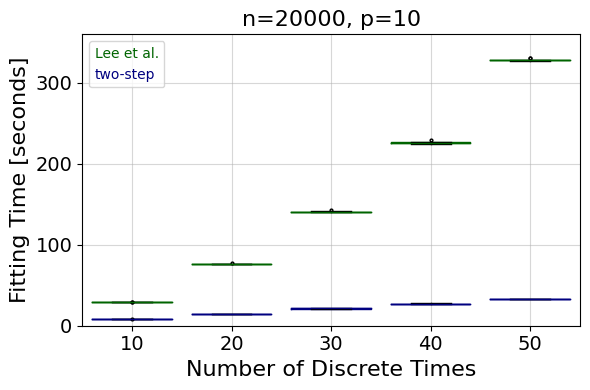

In [10]:
filename = 'fitting_time_comparison.png'

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_title('n=20000, p=10', fontsize=16)
flierprops = dict(marker='.', markersize=4)
lee_boxprops = dict(color='darkgreen')
lee_medianprops = dict(color='darkgreen')
two_step_boxprops = dict(color='navy')
two_step_medianprops = dict(color='navy')

ax.boxplot(lee_results_df, vert=True, positions=lee_results_df.columns, whis=1.5, flierprops=flierprops,
           widths=8, boxprops=lee_boxprops, medianprops=lee_medianprops)
ax.boxplot(two_step_results_df, vert=True, positions=two_step_results_df.columns, whis=1.5, flierprops=flierprops,
           widths=8, boxprops=two_step_boxprops, medianprops=two_step_medianprops)
ax.set_xlabel('Number of Discrete Times', fontsize=16)
ax.set_ylabel('Fitting Time [seconds]', fontsize=16)
ax.set_xticks(d_times_list)
ax.set_xticklabels(d_times_list)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlim([5,55])
ax.set_ylim([0, 360])
# ax.legend()
leg = ax.legend(['Lee et al.', 'two-step'], handlelength=0, handletextpad=0)
color_l = ['darkgreen', 'navy']
for n, text in enumerate( leg.texts ):
    text.set_color( color_l[n] )

    ax.grid(alpha=0.5)

fig.tight_layout()
if filename is not None:
    fig.savefig(os.path.join(OUTPUT_DIR, filename), dpi=300)

References

[1] Meir, Tomer, Gutman, Rom, and Gorfine, Malka, “PyDTS: A Python Package for Discrete-Time Survival Analysis with Competing Risks” (2022)

[2] Lee, Minjung and Feuer, Eric J. and Fine, Jason P., “On the analysis of discrete time competing risks data”, Biometrics (2018) doi: 10.1111/biom.12881